In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Direct download link modification
df1_url = "https://www.dropbox.com/scl/fi/8qff47htxopyku3k8u1lo/df_final_experiment_clients.csv?rlkey=nepmdruop6dmtko0dbomv8zla&dl=1"
df2_url= "https://www.dropbox.com/scl/fi/ibyqzf7ppqpyixl6yy0qm/df_final_demo.csv?rlkey=rnxuqtw9myo9j6xm2z7h6aslo&st=b2392lte&dl=1"
df3_url = "https://www.dropbox.com/scl/fi/z6jeur8hnu7i7ckajnwuo/df_final_web_data_pt_1.txt?rlkey=jk1ux1ut5fsx8831ntd3bb3nb&st=awnzel22&dl=1"
df4_url= "https://www.dropbox.com/scl/fi/vb1zpc1v249r145vbu3az/df_final_web_data_pt_2.txt?rlkey=x4uooym9ssxa3l1ejabhkrux2&st=wzsz600a&dl=1"

# Read the file using pandas
df_final_experiment_clients = pd.read_csv(df1_url, delimiter=',', on_bad_lines='skip') # Test group
df_final_demo = pd.read_csv(df2_url, delimiter=',', on_bad_lines='skip') # Demographic information
df_pt1 = pd.read_csv(df3_url, delimiter=',', on_bad_lines='skip') # Control Group 1
df_pt2 = pd.read_csv(df4_url, delimiter=',', on_bad_lines='skip') # Control Group 2

In [ ]:
## Preparing data for analysis

# Merge the Control Group datasets
df_final_web_data = pd.concat([df_pt1, df_pt2], ignore_index=True)

# Combining the control group with test group
df_joined = df_final_web_data.merge(df_final_experiment_clients, on='client_id')

# Dropping unnecessary columns
df_final_demo = df_final_demo.drop(columns=['clnt_tenure_yr', 'clnt_tenure_mnth', 'gendr',
                                'num_accts', 'bal', 'calls_6_mnth',	'logons_6_mnth'],
                                errors='ignore')

# Finally joining all the necessary data
df_final = df_final_demo.merge(df_joined, on='client_id')

# Properly renaming columns
df_final = df_final.rename(columns={
    'visitor_id': 'device_id', # ID of device the process was executed in
    'visit_id': 'session_id',  # ID of the session the process was executed in
    'Variation': 'variation',
    'clnt_age': 'client_age'})

# Dropping every null value
df_final = df_final.dropna()

# Changing data types for proper analysis
df_final['client_age'] = df_final['client_age'].astype(int)

# Dropping duplicate values
df_final = df_final.drop_duplicates()

# Brief information about data
print(df_final.info())
print('-------------------------------------------')
print(df_final.describe())

<ipython-input-53-7d039dba49bb>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['client_age'] = df_final['client_age'].astype(int)


<class 'pandas.core.frame.DataFrame'>
Index: 317123 entries, 0 to 321308
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     317123 non-null  int64 
 1   client_age    317123 non-null  int64 
 2   device_id     317123 non-null  object
 3   session_id    317123 non-null  object
 4   process_step  317123 non-null  object
 5   date_time     317123 non-null  object
 6   variation     317123 non-null  object
dtypes: int64(2), object(5)
memory usage: 19.4+ MB
None
-------------------------------------------
          client_id     client_age
count  3.171230e+05  317123.000000
mean   5.009926e+06      48.237577
std    2.873247e+06      15.651841
min    5.550000e+02      17.000000
25%    2.516332e+06      34.000000
50%    5.049084e+06      50.000000
75%    7.470491e+06      61.000000
max    9.999832e+06      96.000000


In [ ]:
# Determining the client behavior analysis
df_final['client_age'].describe()

count    317123.000000
mean         48.237577
std          15.651841
min          17.000000
25%          34.000000
50%          50.000000
75%          61.000000
max          96.000000
Name: client_age, dtype: float64

In [ ]:
# Frequency table for age
frequency_table = df_final['client_age'].value_counts()

# Calculating the proportion of each unique value of the client ages
proportion_table = df_final['client_age'].value_counts(normalize=True)

frequency_table, proportion_table

(client_age
 62    7951
 58    7846
 57    7797
 59    7769
 55    7465
       ... 
 91      64
 93      59
 94      29
 96      10
 95       6
 Name: count, Length: 80, dtype: int64,
 client_age
 62    0.025072
 58    0.024741
 57    0.024587
 59    0.024498
 55    0.023540
         ...   
 91    0.000202
 93    0.000186
 94    0.000091
 96    0.000032
 95    0.000019
 Name: proportion, Length: 80, dtype: float64)

<Axes: xlabel='client_age', ylabel='Count'>

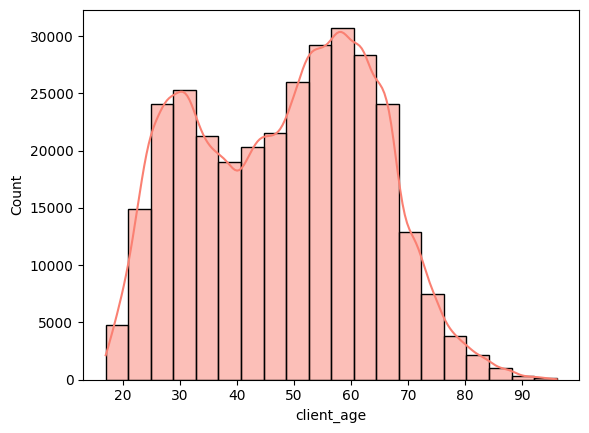

In [ ]:
import seaborn as sns
sns.histplot(df_final['client_age'], kde=True, bins=20, color="salmon")

It looks like most of Vanguards clients are in their late 50s, but a considerate amount are in their late 20s.

In [ ]:
## Prepare data for analysis

# Define a function to categorize age
def categorize_age(age):
    if 17 <= age <= 34:
        return '17-34'
    elif 35 <= age <= 50:
        return '35-50'
    elif 51 <= age <= 60:
        return '51-60'
    elif age >= 61:
        return '61+'
    else:
        return 'Unknown'

# Apply function to the 'client_age' column
df_final['age_category'] = df_final['client_age'].apply(categorize_age)

In [ ]:
# Group by 'variation' and unique values of 'client_id'
variation_count = df_final.groupby('variation')['client_id'].nunique().reset_index()
variation_count.columns = ['variation', 'total_participants']
variation_count

,variation,total_participants
0,Control,23526
1,Test,26961


In [ ]:
# Filter and aggregate the data to count distinct process steps for each client and variation
process_step_count = df_final.groupby(['client_id', 'variation'])['process_step'].nunique().reset_index()

# Filter clients who completed all 5 steps
process_step_count = process_step_count[process_step_count['process_step'] == 5]

# Calculate the number of clients who completed the process, grouped by variation
completed_process_count = process_step_count.groupby('variation')['client_id'].count().reset_index()
completed_process_count.columns = ['variation', 'completed_process_count']

# Calculate the record count for each variation
record_count = df_final.groupby('variation')['client_id'].nunique().reset_index()
record_count.columns = ['variation', 'record_count']

# Merge the results into a single DataFrame
df_completion_rate = pd.merge(completed_process_count, record_count, on='variation')

# Calculate the completion rate and add it as a new column
df_completion_rate['completion_rate'] = (df_completion_rate['completed_process_count'] / df_completion_rate['record_count']).round(2)

# Select only the relevant columns
df_result = df_completion_rate[['variation', 'completion_rate']]

# Sort the results for better readability
df_result = df_result.sort_values(by='variation').reset_index(drop=True)
df_result

,variation,completion_rate
0,Control,0.65
1,Test,0.68


Conclusion:

- The Test Group has a higher completion rate (68%) compared to the Control Group (65%).

In [ ]:
# Filter and aggregate the data to count distinct process steps for each client
process_step_count = df_final.groupby('client_id')['process_step'].nunique().reset_index()

# Filter clients who completed all 5 steps
process_step_count = process_step_count[process_step_count['process_step'] == 5]

# Merge to get the age categories
process_step_count = process_step_count.merge(df_final[['client_id', 'age_category']], on='client_id', how='left').drop_duplicates()

# Calculate the number of clients who completed the process, grouped by age category
completed_process_count = process_step_count.groupby('age_category')['client_id'].count().reset_index()
completed_process_count.columns = ['age_category', 'completed_process_count']

# Calculate the record count for each age category
record_count = df_final.groupby('age_category')['client_id'].nunique().reset_index()
record_count.columns = ['age_category', 'record_count']

# Merge the results into a single DataFrame
df_completion_rate_age = pd.merge(completed_process_count, record_count, on='age_category')

# Calculate the completion rate and add it as a new column
df_completion_rate_age['completion_rate'] = (df_completion_rate_age['completed_process_count'] / df_completion_rate_age['record_count']).round(2)

# Sort the results for better readability
df_completion_rate_age = df_completion_rate_age.sort_values(by='age_category').reset_index(drop=True)
df_completion_rate_age

,age_category,completed_process_count,record_count,completion_rate
0,17-34,9647,13876,0.70
1,35-50,9563,14009,0.68
2,51-60,7400,11150,0.66
3,61+,6923,11452,0.60


Conclusion:

- Younger clients seem to have a better completion rate compared to older clients.

In [ ]:
# Filter and aggregate the data to count distinct process steps for each client, age category, and variation
process_step_count = df_final.groupby(['client_id', 'age_category', 'variation'])['process_step'].nunique().reset_index()

# Filter clients who completed all 5 steps
process_step_count = process_step_count[process_step_count['process_step'] == 5]

# Calculate the number of clients who completed the process, grouped by age category and variation
completed_process_count = process_step_count.groupby(['age_category', 'variation'])['client_id'].count().reset_index()
completed_process_count.columns = ['age_category', 'variation', 'completed_process_count']

# Calculate the record count for each age category and variation
record_count = df_final.groupby(['age_category', 'variation'])['client_id'].nunique().reset_index()
record_count.columns = ['age_category', 'variation', 'record_count']

# Merge the results into a single DataFrame
df_age_variation_completion_rate = pd.merge(completed_process_count, record_count, on=['age_category', 'variation'])

# Calculate the completion rate and add it as a new column
df_age_variation_completion_rate['completion_rate'] = (df_age_variation_completion_rate['completed_process_count'] / df_age_variation_completion_rate['record_count']).round(2)
df_age_variation_completion_rate.sort_values('age_category')

,age_category,variation,completed_process_count,record_count,completion_rate
0,17-34,Control,4245,6358,0.67
1,17-34,Test,5402,7518,0.72
2,35-50,Control,4357,6502,0.67
3,35-50,Test,5206,7507,0.69
4,51-60,Control,3420,5242,0.65
5,51-60,Test,3980,5908,0.67
6,61+,Control,3178,5424,0.59
7,61+,Test,3745,6028,0.62


In [ ]:
# Count the occurrences of each step for each client and variation
step_counts = df_final.groupby(['client_id', 'variation', 'process_step']).size().reset_index(name='step_count')

# Identify repeated steps (count greater than 1)
repeated_steps = step_counts[step_counts['step_count'] > 1]

# Sum the repeated steps for each client and variation
repeated_steps_summary = repeated_steps.groupby(['client_id', 'variation'])['step_count'].sum().reset_index()

# Calculate the total number of repeated steps for each variation
repeated_steps_by_variation = repeated_steps_summary.groupby('variation')['step_count'].sum().reset_index()
repeated_steps_by_variation.columns = ['variation', 'total_repeated_steps']
repeated_steps_by_variation

,variation,total_repeated_steps
0,Control,69924
1,Test,96576


In [ ]:
# Filter to include only the middle steps ('step_1', 'step_2', 'step_3')
middle_steps = df_final[df_final['process_step'].isin(['step_1', 'step_2', 'step_3'])]

# Group by client_id, variation, and process_step to count occurrences
step_counts = middle_steps.groupby(['client_id', 'variation', 'process_step']).size().reset_index(name='step_count')

# Calculate the average count per step for each variation
average_step_counts = step_counts.groupby(['variation', 'process_step'])['step_count'].mean().reset_index()

# Round the average count to 2 decimal places
average_step_counts['step_count'] = average_step_counts['step_count'].round(2)

# Rename columns for clarity
average_step_counts.columns = ['variation', 'process_step', 'average_count']
average_step_counts

,variation,process_step,average_count
0,Control,step_1,1.47
1,Control,step_2,1.38
2,Control,step_3,1.29
3,Test,step_1,1.59
4,Test,step_2,1.39
5,Test,step_3,1.23


In [ ]:
# Group by client_id, variation, age_category, and process_step to count occurrences
step_counts = middle_steps.groupby(['client_id', 'variation', 'age_category', 'process_step']).size().reset_index(name='step_count')

# Calculate the average count per step for each age category and variation
average_step_counts = step_counts.groupby(['age_category', 'variation', 'process_step'])['step_count'].mean().reset_index()

# Round the average count to 2 decimal places
average_step_counts['step_count'] = average_step_counts['step_count'].round(2)

# Rename columns for clarity
average_step_counts.columns = ['age_category', 'variation', 'process_step', 'average_count']
average_step_counts

,age_category,variation,process_step,average_count
0,17-34,Control,step_1,1.37
1,17-34,Control,step_2,1.34
2,17-34,Control,step_3,1.26
3,17-34,Test,step_1,1.43
4,17-34,Test,step_2,1.22
5,17-34,Test,step_3,1.10
6,35-50,Control,step_1,1.41
7,35-50,Control,step_2,1.33
8,35-50,Control,step_3,1.23
9,35-50,Test,step_1,1.47


In [ ]:
# Calculate completion rates for control and test groups
variation_count = df_final.groupby('variation')['client_id'].nunique().reset_index()
variation_count.columns = ['variation', 'total_participants']

# Filter and aggregate the data to count distinct process steps for each client and variation
process_step_count = df_final.groupby(['client_id', 'variation'])['process_step'].nunique().reset_index()
process_step_count = process_step_count[process_step_count['process_step'] == 5]

# Calculate the number of clients who completed the process, grouped by variation
completed_process_count = process_step_count.groupby('variation')['client_id'].count().reset_index()
completed_process_count.columns = ['variation', 'completed_process_count']

# Merge the results into a single DataFrame
df_completion_rate = pd.merge(completed_process_count, variation_count, on='variation')
df_completion_rate['completion_rate'] = (df_completion_rate['completed_process_count'] / df_completion_rate['total_participants']).round(3)
print(df_completion_rate)

# Perform the two-proportion z-test
completed_control = df_completion_rate[df_completion_rate['variation'] == 'Control']['completed_process_count'].values[0]
completed_test = df_completion_rate[df_completion_rate['variation'] == 'Test']['completed_process_count'].values[0]
total_control = df_completion_rate[df_completion_rate['variation'] == 'Control']['total_participants'].values[0]
total_test = df_completion_rate[df_completion_rate['variation'] == 'Test']['total_participants'].values[0]

count = np.array([completed_test, completed_control])
nobs = np.array([total_test, total_control])
stat, pval = proportions_ztest(count, nobs, alternative='larger')

print(f'z-statistic: {stat}')
print(f'p-value: {pval}')

# Decision based on p-value
alpha = 0.05
if pval < alpha:
    print("Reject the null hypothesis: The test group has a significantly better completion rate.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in completion rates.")

  variation  completed_process_count  total_participants  completion_rate
0   Control                    15200               23526            0.646
1      Test                    18333               26961            0.680
z-statistic: 8.042888443902605
p-value: 4.3872601015481086e-16
Reject the null hypothesis: The test group has a significantly better completion rate.


In [ ]:
from scipy.stats import ttest_ind

# Filter to include only the middle steps ('step_1', 'step_2', 'step_3')
middle_steps = df_final[df_final['process_step'].isin(['step_1', 'step_2', 'step_3'])]

# Group by client_id, variation, and process_step to count occurrences
step_counts = middle_steps.groupby(['client_id', 'variation', 'process_step']).size().reset_index(name='step_count')

# Calculate the average count per step for each variation
average_step_counts = step_counts.groupby(['client_id', 'variation'])['step_count'].mean().reset_index()

# Separate the data into control and test groups
control_group = average_step_counts[average_step_counts['variation'] == 'Control']['step_count']
test_group = average_step_counts[average_step_counts['variation'] == 'Test']['step_count']

# Perform two-sample t-test
stat, pval = ttest_ind(control_group, test_group, alternative='greater')

print(f't-statistic: {stat}')
print(f'p-value: {pval}')

# Decision based on p-value
alpha = 0.05
if pval < alpha:
    print("Reject the null hypothesis: The test group has significantly fewer repeated steps.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the number of repeated steps.")


t-statistic: -4.455231470023022
p-value: 0.9999957996606544
Fail to reject the null hypothesis: There is no significant difference in the number of repeated steps.
